## Fitting Ne lines in a loop
- This notebook shows how to fit all lines in a folder defined by path
- You tweak the fit for a single line, and then use this to fit all lines. You can then refit lines with high residuals/offsets differing from the rest

## Downloading locally
- The easiest way to install diad fit is by removing the #, and running this once per computer. When I update the code, you'll need to get the new tag off GitHub:
https://github.com/PennyWieser/DiadFit/tags
Right click on the top one, over the 'zip' icon, click copy link address
- Remove the # in the line below. Run only once for each computer!
![image.png](attachment:5a0e0d97-4380-4cb2-bf26-d0ab6ee7458a.png)

In [1]:
#!pip install --upgrade "https://github.com/PennyWieser/DiadFit/archive/refs/tags/v.0.23.zip"

### This imports DiadFit, and gives you the version. In all communication with Penny, make sure you say the version!

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
pf.__version__

'0.0.23'

## Extracting metadata

In [3]:
 # Path to metadata files for Ne. Easier to have in subfolder
meta_path=r'/Users/kyledayton/Downloads/09.27.22 LM6 G6 MI3/09.27.22 Text Files'
spectra_path=r'/Users/kyledayton/Downloads/09.27.22 LM6 G6 MI3/09.27.22 Spectra/NE Spectra'

# Find files


# Put the common string you can in all your Ne lines here
ID_str='NE '
file_ext_meta='txt' # Will only take files of this type 
exclude_str='png' # Will exclude files of this type, sometimes images have same name
 # Leave as none unless witec appended a number
Ne_files_meta=pf.get_Ne_files(path=meta_path, file_ext=file_ext_meta, ID_str=ID_str, 
                         exclude_str=exclude_str, sort=True)

Ne_files_meta


['NE 1.txt', 'NE 2.txt', 'NE 3.txt', 'NE 4.txt']

In [4]:
## Image file says Video Image

In [5]:
# Extract useful metadata from each file
meta=pf.stitch_metadata_in_loop(path=meta_path, Allfiles=Ne_files_meta, prefix=False, trupower=True)
meta.head()

100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 942.96it/s]


Done


,filename,date,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,index
0,NE 1.txt,"September 27, 2022\n",5.023,45.0,3.0,100.0,"['0h', '2m', '18s']",4:14:08 PM\n,58448.0,1325.0,0
1,NE 2.txt,"September 27, 2022\n",5.024,45.0,3.0,100.0,"['0h', '2m', '17s']",4:20:37 PM\n,58837.0,1325.0,1
2,NE 3.txt,"September 27, 2022\n",5.023,45.0,3.0,100.0,"['0h', '2m', '17s']",4:28:40 PM\n,59320.0,1325.0,2
3,NE 4.txt,"September 27, 2022\n",5.026,45.0,3.0,100.0,"['0h', '2m', '17s']",4:47:33 PM\n,60453.0,1325.0,3


## Get Ne line positions for your specific laser wavelength
- At the moment, this returns any Ne lines with intensity >2000 in the NIST databook, although you can change this!

In [6]:
wavelength =532.067 # Specify the specific wavelength of your laser 
df_Ne=pf.calculate_Ne_line_positions(wavelength=wavelength, cut_off_intensity=2000)
df_Ne.head()

,Raman_shift (cm-1),Intensity,Ne emission line in air
1,817.957694,5000.0,556.27662
9,1116.345158,5000.0,565.66588
16,1309.738376,5000.0,571.92248
19,1398.173304,5000.0,574.82985
23,1446.822793,7000.0,576.44188


## Calculate the ideal distance between the two lines you are selecting
- This finds the closest line in the table above for the line shift you have written down

In [7]:
line_1=1117
line_2=1447
ideal_split=pf.calculate_Ne_splitting(wavelength=wavelength, 
                                      line1_shift=line_1, line2_shift=line_2,
                                     cut_off_intensity=2000)
ideal_split

,Ne_Split,Line_1,Line_2,Entered Pos Line 1,Entered Pos Line 2
0,330.477634,1116.345158,1446.822793,1117,1447


## Find your Ne spectra files

In [8]:
filetype='headless_txt'
# Put the common string you can in all your Ne lines here
ID_str='NE '
file_ext='txt' # Will only take files of this type 
exclude_str='png' # Will exclude files of this type, sometimes images have same name
prefix=True # Leave as none unless witec appended a number
Ne_files=pf.get_Ne_files(path=spectra_path, file_ext=file_ext, ID_str=ID_str, exclude_str=exclude_str, sort=True)

In [9]:
Ne_files

['NE 1.txt', 'NE 2.txt', 'NE 3.txt', 'NE 4.txt']

## Select the first file you want to fit
- You can either do this numerically, or by specifiying the filename between ''

In [10]:
filename=Ne_files[0]  # Or you could put a string here, like 'NE1.txt' 

## Plot Ne lines to inspect
- This function allows you to inspect your spectra, and also uses scipy find peaks to get a first guess of the peak positions, which speeds up the voigt fitting in the later part of the notebook

Biggest 6 peaks:


,pos,height
54,1447.878781,22721.000000
49,1399.406110,6293.000000
68,1567.514917,4290.333496
10,1118.069988,2470.000000
25,1220.505213,1932.666626
37,1311.278432,1683.000000


selected Peak 1 Pos
1118.069988
selected Peak 2 Pos
1447.878781


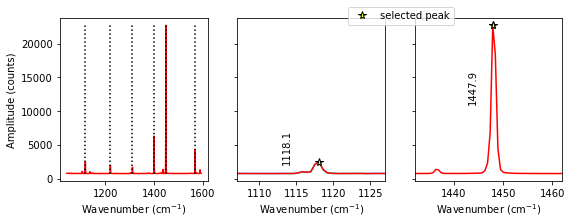

In [11]:
# Specify the approximate peak positions of the lines you are interested in
# If your drift is off the real positions, you'll have to tweak these numbers
peak1_cent=line_1 # approximate position of the 1st line you are interested in
peak2_cent=line_2 # Approximate position of the 2nd line you are interested in


Ne, df_sort_Ne_trim, nearest_pk1, nearest_pk2=pf.plot_Ne_lines(path=spectra_path, filename=filename, filetype=filetype, 
n_peaks=6, peak1_cent=peak1_cent, peak2_cent=peak2_cent,
height=10, threshold=0.6, distance=1, prominence=10, width=1, exclude_range_1=None,
exclude_range_2=None)

## You can tweak parameters here
- The default parameters may work, you can see what those are here:
- Most important things, the number of peaks you want for 1117, and the offset for this peak (LH_offset_min) if you are fitting the 1117 line as you need 2 peaks
- By default, the function applies the fit to all the points inside the outermost background positions. This can be trimmed using x_span_pk1_override, and x_span_pk2_override
- See figure from Penny for what these parameters actually are

In [12]:
pf.Ne_peak_config()

Ne_peak_config(N_poly_pk1_baseline=1, N_poly_pk2_baseline=1, lower_bck_pk1=(-50, -25), upper_bck1_pk1=(8, 15), upper_bck2_pk1=(30, 50), lower_bck_pk2=(-44.2, -22), upper_bck1_pk2=(15, 50), upper_bck2_pk2=(50, 51), x_range_baseline=20, y_range_baseline=200, pk1_amplitude=100, pk2_amplitude=100, x_range_peak=15, x_range_residual=7, LH_offset_mini=(1.5, 3), x_span_pk1=None, x_span_pk2=None)

- You can also overwrite any of these, the most likely things you'll want to overwrite are the background positions, or the amplitude

In [13]:
Ne_Config=pf.Ne_peak_config(pk1_amplitude=40, pk2_amplitude=100, LH_offset_mini=[2, 5], 
lower_bck_pk1=(-60, -25), upper_bck1_pk1=[40, 70], upper_bck2_pk1=[40, 70],
lower_bck_pk2=[-40, -30], upper_bck1_pk2=[10, 15], upper_bck2_pk2=[25, 40],
x_range_peak=15, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10], N_poly_pk2_baseline=2 )
Ne_Config

Ne_peak_config(N_poly_pk1_baseline=1, N_poly_pk2_baseline=2, lower_bck_pk1=(-60, -25), upper_bck1_pk1=[40, 70], upper_bck2_pk1=[40, 70], lower_bck_pk2=[-40, -30], upper_bck1_pk2=[10, 15], upper_bck2_pk2=[25, 40], x_range_baseline=20, y_range_baseline=200, pk1_amplitude=40, pk2_amplitude=100, x_range_peak=15, x_range_residual=7, LH_offset_mini=[2, 5], x_span_pk1=[-10, 8], x_span_pk2=[-10, 10])

,filename,pk2_peak_cent,pk2_amplitude,pk2_sigma,pk2_gamma,error_pk2,pk1_peak_cent,pk1_amplitude,pk1_sigma,pk1_gamma,error_pk1,deltaNe,Ne_Corr,Ne_Corr_min,Ne_Corr_max,residual_pk2,residual_pk1,residual_pk1+pk2
0,1.txt,1448.078234,30433.694959,0.246986,0.246986,0.00415,1117.874971,2588.443747,0.277338,0.277338,NaN,330.203262,1.000831,NaN,NaN,137.007636,21.161989,158.169624


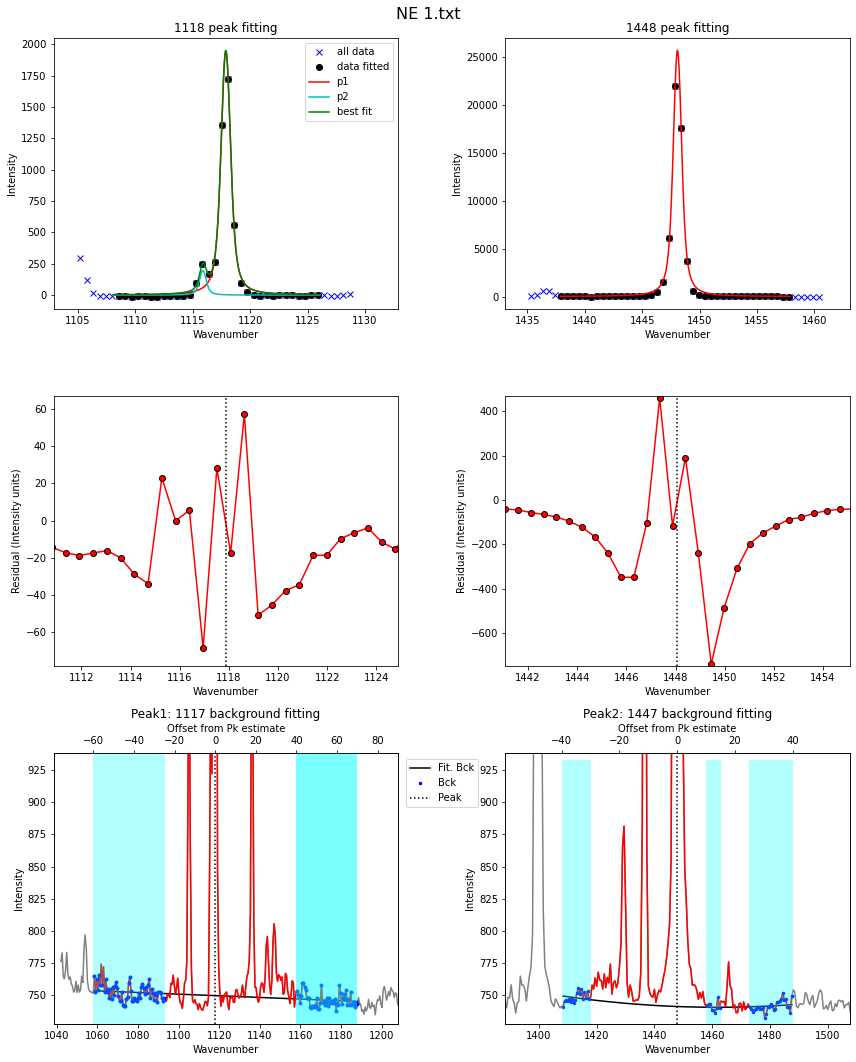

In [14]:
# You also need to set whether you want 1 peak or 2 for the LH diad
peaks_1=2

df_test=pf.fit_Ne_lines(  
    config=Ne_Config, peaks_1=peaks_1,
    Ne=Ne, filename=filename, path=spectra_path, prefix=prefix,
    Ne_center_1=nearest_pk1, Ne_center_2=nearest_pk2,
    DeltaNe_ideal=ideal_split['Ne_Split'])                                                                 
                                                                     
        
display(df_test)

## Now you can loop over all files using these parameters
- Most important thing you can change is plot_figure=False, much quicker, but wont save or show figures, plot_figure=True will)
- If you need, you can add other parameters in the loop here. 

In [15]:
len(Ne_files)

4

100%|█████████████████████████████████████████████| 4/4 [00:02<00:00,  1.37it/s]


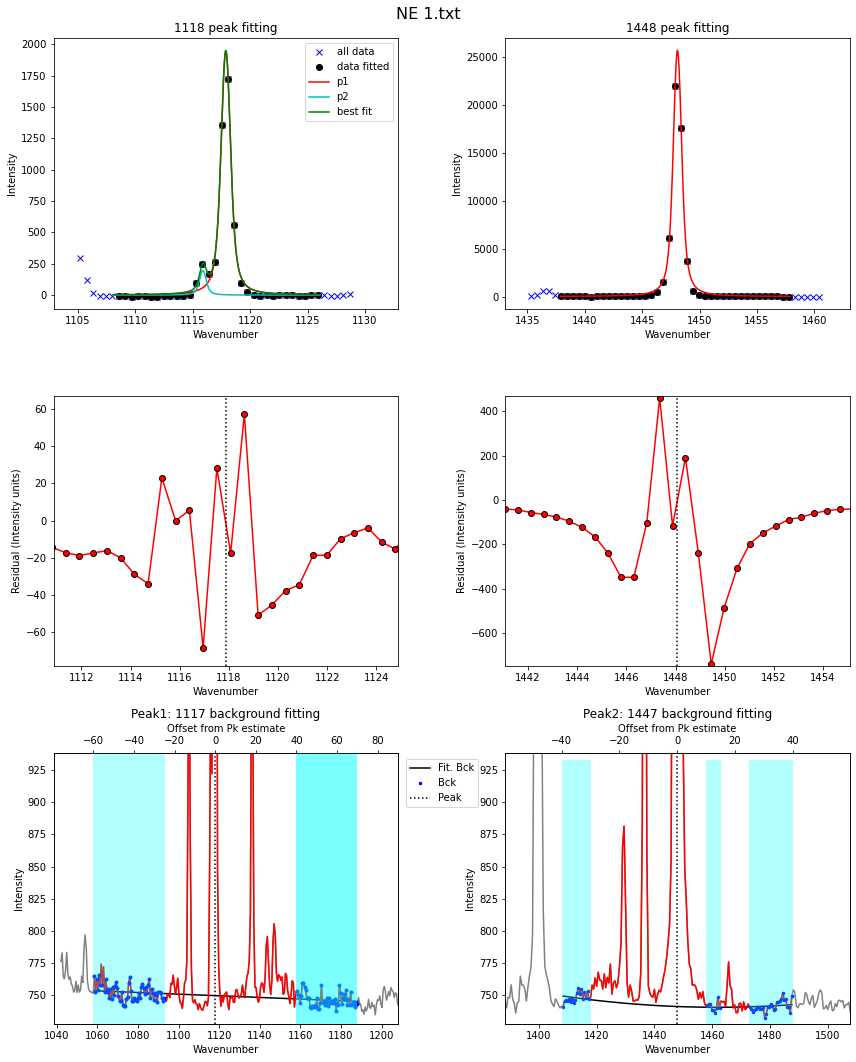

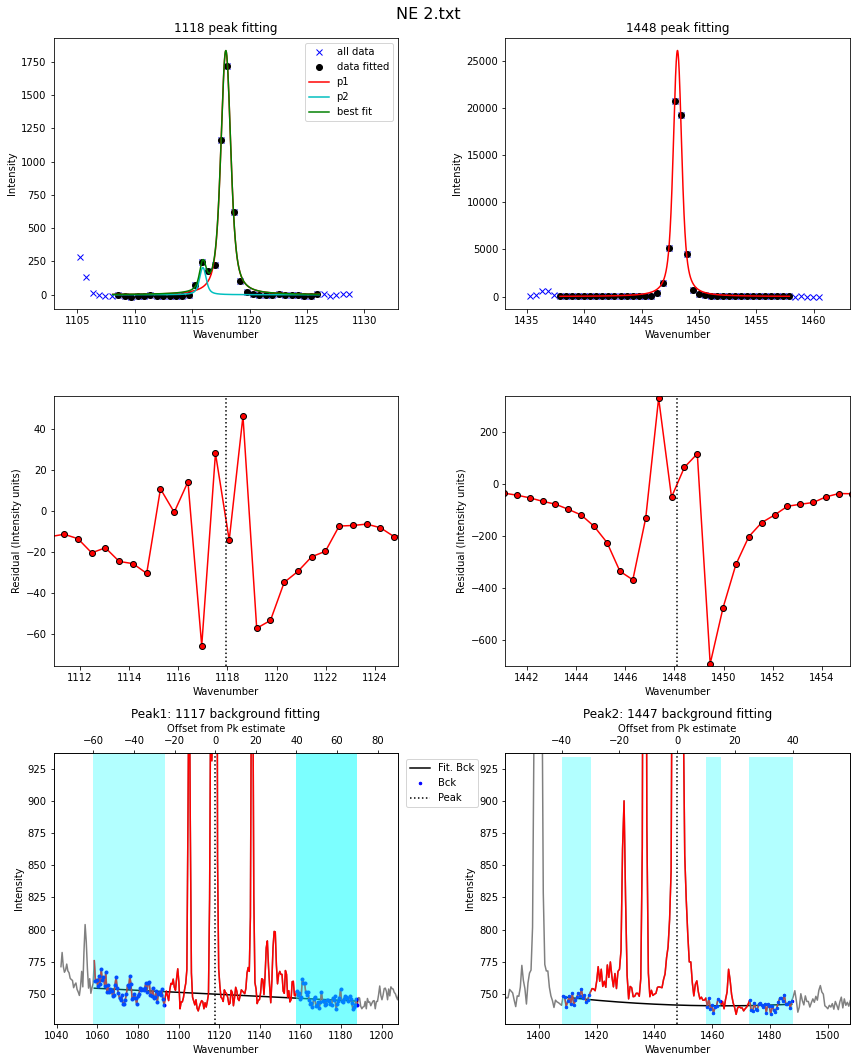

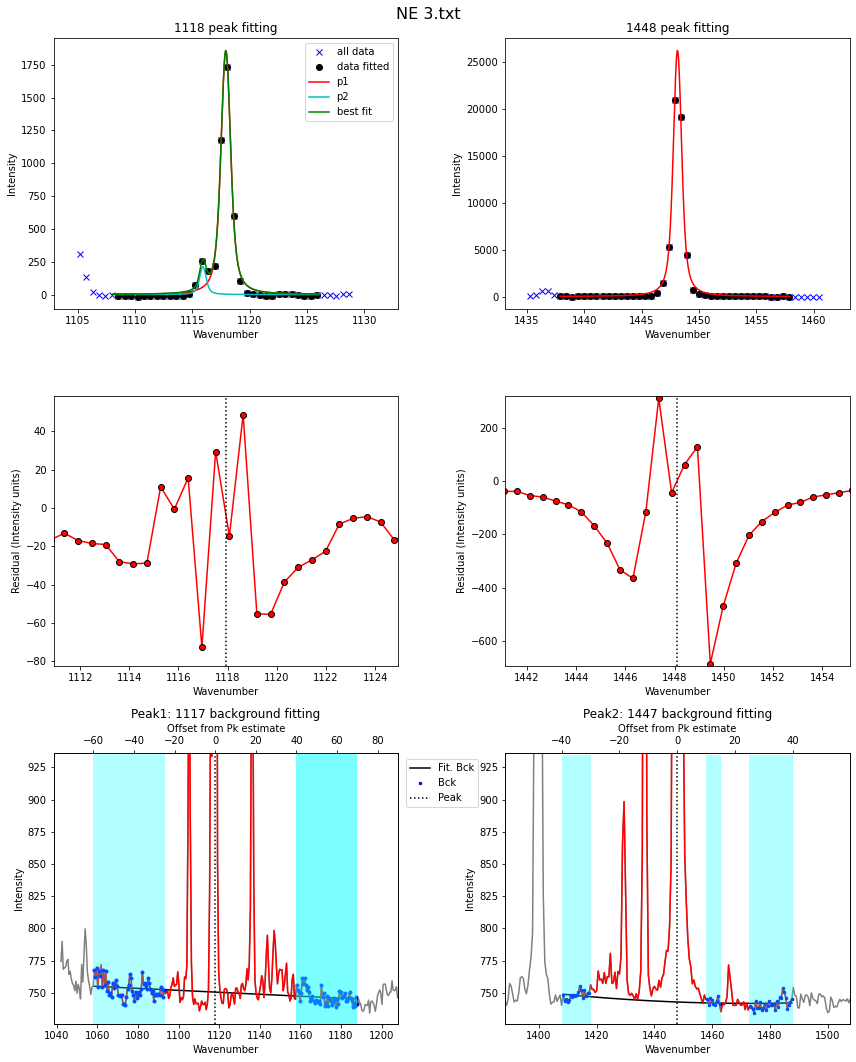

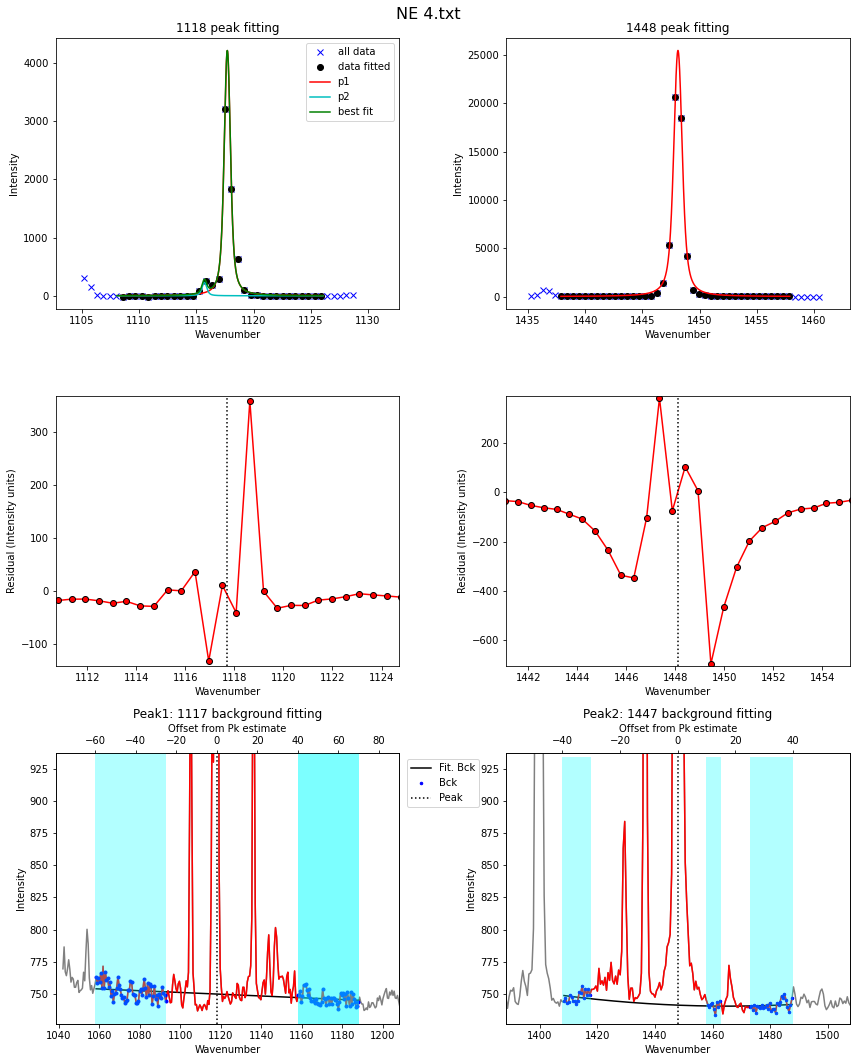

In [16]:
df2=pf.loop_Ne_lines(files=Ne_files, path=spectra_path, filetype=filetype,
                  config=Ne_Config, peaks_1=2, Ne=Ne, Ne_center_1=nearest_pk1,
                  Ne_center_2=nearest_pk2, DeltaNe_ideal=ideal_split['Ne_Split'], 
                  plot_figure=True, save_clipboard=True, single_acq=False)

# If any are weird, can fit again here
- If you refit, you'll have to replace the value in the saved dataframe

In [17]:
# # Which file
# filename2=Ne_files[1]  # Or you could put a string here, like 'NE1.txt' 

# # Tweak fit

# Ne_Config2=pf.Ne_peak_config(amplitude=100, LH_offset_mini=[2, 5], 
# lower_bck_pk1=(-50, -30), upper_bck1_pk1=[7, 13], upper_bck2_pk1=[50, 80],
# lower_bck_pk2=[-40, -30], upper_bck1_pk2=[15, 50], upper_bck2_pk2=[50, 80],
# x_range_peak=15, x_span_pk1=[-10, 8], x_span_pk2=[-10, 10])
# Ne_Config

# # You also need to set whether you want 1 peak or 2 for the LH diad
# peaks_1=2

# df_test=pf.fit_Ne_lines(  
#     config=Ne_Config2, peaks_1=peaks_1,
#     Ne=Ne, filename=filename2, path=spectra_path, prefix=prefix,
#     Ne_center_1=nearest_pk1, Ne_center_2=nearest_pk2,
#     DeltaNe_ideal=ideal_split['Ne_Split'])                                                                 
                                                                     
        
# #config: Ne_peak_config=Ne_peak_config(),

## Stitching meta data with Ne line data

In [18]:
# See what deliminators you have in your metadata file you have just got
print(meta['filename'][0])

NE 1.txt


In [19]:
# remove these to get the pure file name you can compare 
file_m=pf.extracting_filenames_generic(names=meta['filename'],
   file_type='.txt')

file_m

array(['NE 1', 'NE 2', 'NE 3', 'NE 4'], dtype=object)

In [20]:
type(file_m)

numpy.ndarray

In [21]:
# See what file names you have for your actual datafiles
print(df2['filename'][0])

NE 1.txt


In [23]:
# Remove these to get the pure file name
file_s=pf.extracting_filenames_generic(names=df2['filename'],
    prefix=False, str_prefix=' ',
   file_type='.txt')
file_s

array(['NE 1', 'NE 2', 'NE 3', 'NE 4'], dtype=object)

## Now combining them

In [24]:
meta['name_for_matching']=file_m
df2['name_for_matching']=file_s
df_combo=df2.merge(meta, on='name_for_matching')

## Now lets inspect what our Ne correction factors actually look like

In [25]:
help(pf.plot_Ne_corrections)

Help on function plot_Ne_corrections in module DiadFit.ne_lines:

plot_Ne_corrections(df=None, x_axis=None, x_label='index', marker='o', mec='k', mfc='r')
    ## Plot to help inspect which Ne lines to discard



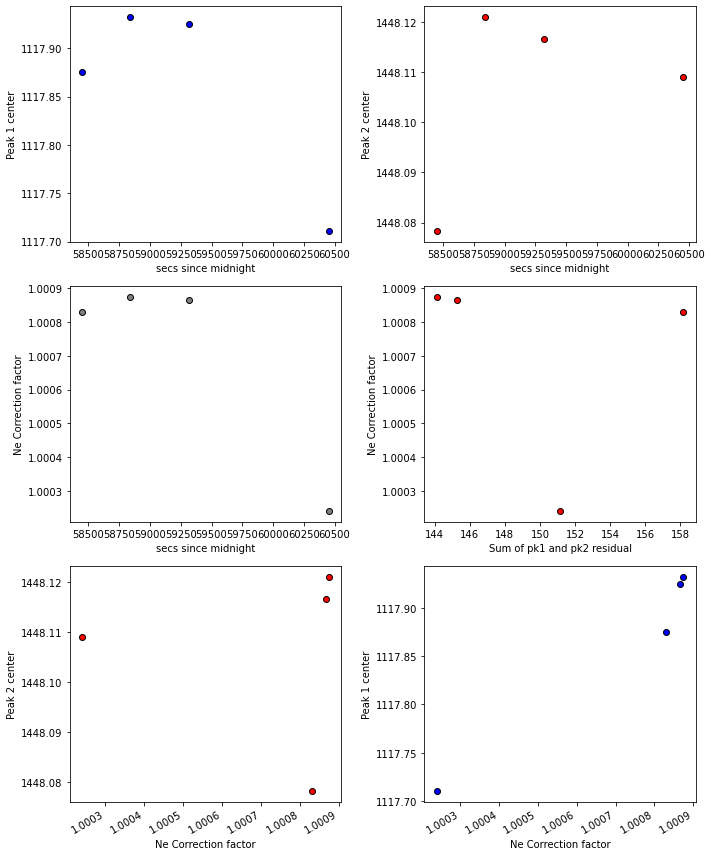

In [26]:
fig=pf.plot_Ne_corrections(df=df_combo, x_axis=df_combo['sec since midnight'],
                      x_label='secs since midnight')

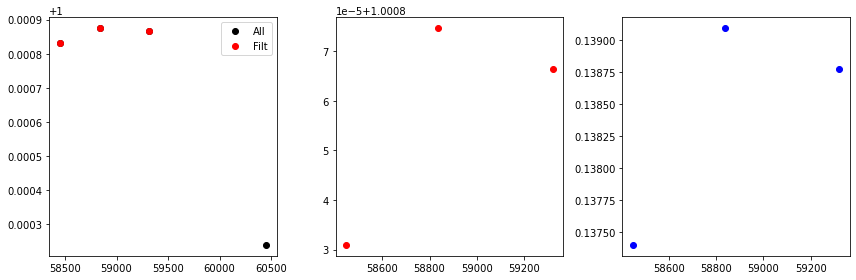

In [27]:
filt=pf.filter_Ne_Line_neighbours(Corr_factor=df_combo['Ne_Corr'], number_av=5, offset=0.0001)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
ax1.plot(df_combo['sec since midnight'], df_combo['Ne_Corr'],   'ok', label='All')
ax1.plot(df_combo['sec since midnight'], filt,  'or', label='Filt')
ax1.legend()
ax2.plot(df_combo['sec since midnight'], filt,  'or', label='Filt')

test_split=103
split=filt*test_split
density_test=pf.calculate_density_cornell(temp='SupCrit', Split=split)
ax3.plot(df_combo['sec since midnight'].loc[density_test['Preferred D']>0],
         density_test['Preferred D'].loc[density_test['Preferred D']>0], 'ob')
fig.tight_layout()

In [28]:
df_combo.to_excel('Ne Lines 09.27.22.xlsx')

In [29]:
df_combo

,filename_x,pk2_peak_cent,pk2_amplitude,pk2_sigma,pk2_gamma,error_pk2,pk1_peak_cent,pk1_amplitude,pk1_sigma,pk1_gamma,...,date,power (mW),Int_time (s),accumulations,Mag (X),duration,24hr_time,sec since midnight,Spectral Center,index
0,NE 1.txt,1448.078234,30433.694959,0.246986,0.246986,0.00415,1117.874971,2588.443747,0.277338,0.277338,...,"September 27, 2022\n",5.023,45.0,3.0,100.0,"['0h', '2m', '18s']",4:14:08 PM\n,58448.0,1325.0,0
1,NE 2.txt,1448.121041,30416.635849,0.242886,0.242886,0.00343,1117.932203,2496.048231,0.284550,0.284550,...,"September 27, 2022\n",5.024,45.0,3.0,100.0,"['0h', '2m', '17s']",4:20:37 PM\n,58837.0,1325.0,1
2,NE 3.txt,1448.116578,30487.181689,0.242648,0.242648,0.00341,1117.925055,2490.748857,0.280053,0.280053,...,"September 27, 2022\n",5.023,45.0,3.0,100.0,"['0h', '2m', '17s']",4:28:40 PM\n,59320.0,1325.0,2
3,NE 4.txt,1448.108980,29814.747889,0.244517,0.244517,0.00360,1117.710581,3678.559385,0.182083,0.182083,...,"September 27, 2022\n",5.026,45.0,3.0,100.0,"['0h', '2m', '17s']",4:47:33 PM\n,60453.0,1325.0,3


## Now lets make a regression against time

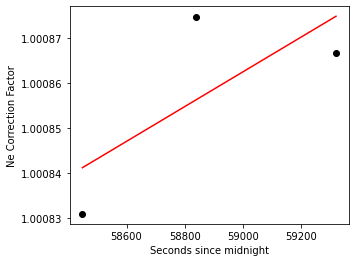

In [31]:
df_combo_filt=df_combo[density_test['Preferred D']>0]
model=pf.reg_Ne_lines_time(df=df_combo_filt, N_poly=1, fit='poly')

## SAving as pickle, can then load as a pickle

In [32]:
import pickle
with open('Ne_Line_Regression_09.27.22.pck', 'wb') as file_handle:
    pickle.dump(model, file_handle)

In [33]:
with open('Ne_Line_Regression_09.27.22.pck', 'rb') as file_handle:
    my_loaded_model = pickle.load(file_handle)

## You can then load these pickles into the notebook where you fit your Diad data|